## Load the data into RAM

CSV


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# `np.uint8` would suffice to represent the greyscale value for each pixel 
# but because sklearn uses double precision internally for a lot of algorithms, 
# we're gonna use `np.float64` from the beginning.
test_data = np.genfromtxt('mnist_test.csv', delimiter=',', dtype=np.float64)
train_data = np.genfromtxt('mnist_train.csv', delimiter=',', dtype=np.float64)

# first column of each row is the digit we want to recognize later
y_test = test_data[:,0]
# the rest of the row's entries are the 28x28 greyscale values
X_test = test_data[:,1:].reshape((-1,28*28))

# same for the training data
y_train = train_data[:,0]
X_train = train_data[:,1:].reshape((-1,28*28))

# see what we end up with
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

## Feature selection

First we examine the data by looking at some digits.

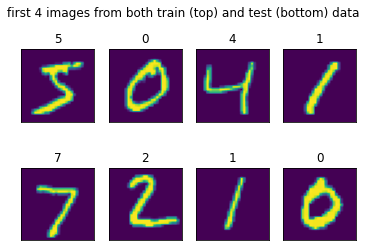

In [2]:
samples = 4
f, axes = plt.subplots(2, samples)
f.suptitle(f'first {samples} images from both train (top) and test (bottom) data')

for i in range(samples):
    # top row
    axes[0][i].imshow(X_train[i].reshape(28,28))
    axes[0][i].set_title("{:.0f}".format(y_train[i]))

    # bottom row
    axes[1][i].imshow(X_test[i].reshape(28,28))
    axes[1][i].set_title("{:.0f}".format(y_test[i]))

    # get rid of axes
    axes[0][i].set_xticks(())
    axes[0][i].set_yticks(())
    axes[1][i].set_xticks(())
    axes[1][i].set_yticks(())

### We investigate which pixel carry information and which ones don't.

By looking at the mean of the training set as image we can clearly see that the pixel towards the edge of the image are more likely to be the same for every digit. Meaning these features really don't have much impact.

> The classes in the sklearn.feature_selection module can be used for feature selection/dimensionality reduction on sample sets, either to improve estimators’ accuracy scores or to boost their performance on very high-dimensional datasets.
>
>VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.
>
> -- <cite>[sklearn](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel)</cite>

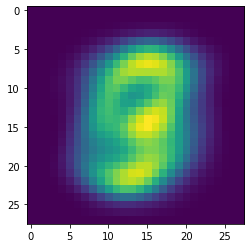

In [3]:
# visualize mean of the training set
plt.imshow(np.mean(X_train.reshape(-1,28,28), axis=0))

In [41]:
from sklearn.feature_selection import VarianceThreshold
# For now we'll just use the default elimination of zero-variance features.
selector = VarianceThreshold()
# TODO: How to get y_transformed???
X_transformed = selector.fit_transform(X_train, y_train)
# we already eliminated 67 features with default=0 threshold
X_transformed.shape

(60000, 717)

## Preprocessing
> The sklearn.preprocessing package provides several common utility functions and transformer classes to change raw feature vectors into a representation that is more suitable for the downstream estimators.
>
> Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.
>
> -- <cite>[sklearn](https://sklearn.org/modules/preprocessing.html#preprocessing)</cite>

So let's standardize features by removing the mean and scaling to unit variance

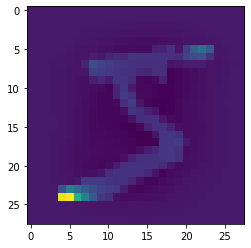

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Standardize features by removing the mean and scaling to unit variance
X_scaled = scaler.fit_transform(X_transformed, y_train)
# example of a scaled digit. inverse feature elimination first
plt.imshow(selector.inverse_transform(X_scaled)[0].reshape(28,28))

## Classify Zero digits
For now we only want to tell '0' from other digits. We need a binary classifier zer/non-zero.
We'll achieve this with a LogisticRegression.

In [53]:
# turn target values into booleans
y_binary = y_train == 0

from sklearn.linear_model import LogisticRegression

# Turn up tolerance for faster convergence
train_samples = X_scaled.shape[0]
clf = LogisticRegression(C=50. / train_samples,
                         multi_class='multinomial',
                         penalty='l1', solver='saga', tol=0.1)
clf.fit(X_scaled, y_binary)

LogisticRegression(C=0.0008333333333333334, multi_class='multinomial',
                   penalty='l1', solver='saga', tol=0.1)

In [55]:
score = clf.score(scaler.transform(selector.transform(X_test)), y_test==0)
score

0.9724

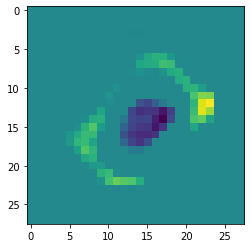

In [64]:
# lets look at the coefficients for classifying the zero digit
# one can definetly recognize a '0' in there
coef = clf.coef_.copy()
plt.imshow(selector.inverse_transform(coef).reshape(28,28))

In [5]:
# conda activate notebooks

In [6]:
# pip install scipy scikit-learn